In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
from scipy import stats
import scipy
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [2]:
# Allele_specific genes
Rawdir="/data2/Hap3D_Figures/figure_processing_data/Fig6/pre_data"
# outdir="/data2/linzhuobin/Hap3D_Figures/pdf"
filename = f"{Rawdir}/TSS_sorted.txt"
genes_df = pd.read_csv(filename, header=None, index_col=None, sep="\t")
genes_df["Position"] = genes_df[2].values

In [3]:
genes_df = genes_df.loc[(genes_df[0]!='chrX') | (genes_df[0]!='chrY')]

In [4]:
def DLRfun(hicdf, Position):
    '''Call DLR'''
    condition = (
        ( hicdf["P1"].between(Position-5000, Position+5000) ) |
        ( hicdf["P2"].between(Position-5000, Position+5000) )
    )
    # 应用过滤条件，统计符合条件的行数
    fdf= hicdf[condition].copy()
    distanct_thred = 1_500_000
    # distal
    Pd = fdf["distance"] >= distanct_thred
    # local
    Pl = fdf["distance"] < distanct_thred
    # cistal counts
    d_counts = fdf.loc[Pd, "counts"].sum()
    # local counts
    l_counts = fdf.loc[Pl, "counts"].sum()
    DLR = d_counts/l_counts
    return(DLR)

In [7]:
holdlist = []
# genedf = imprinted_df.loc[imprinted_df["Chromosome"]==chrom, :].copy()
for chrom, genedf in genes_df.groupby(0):
    if (chrom =='chrX') | (chrom=='chrY'):
        continue
    print(chrom)
    # loading hic contact matrix
    hicfile = f"/data2/Hap3D_Figures/figure_processing_data/Fig6/HiCDPR/HG001_HiC_diploid_contacts_{chrom}.txt"
    hiccontact = pd.read_csv(hicfile, sep="\t", header=None, names=["P1", "P2", "counts"])
    hiccontact["distance"] = abs(hiccontact["P2"].values - hiccontact["P1"].values)

    # Cal DLR
    genedf["DLR"] = genedf["Position"].apply(lambda x: DLRfun(hiccontact, x) )
    holdlist.append(genedf)

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9


In [13]:
DLR_df = pd.concat(holdlist)
del DLR_df["Position"]
DLR_df

,0,1,2,3,4,5,6,DLR
0,chr1,28554,30554,+,lincRNA,promoter,ENSG00000243485.5,inf
1,chr1,35081,37081,-,lincRNA,promoter,ENSG00000237613.2,inf
2,chr1,64419,66419,+,protein_coding,promoter,ENSG00000186092.6,NaN
3,chr1,90105,92105,-,lincRNA,promoter,ENSG00000239945.1,inf
4,chr1,132723,134723,-,lincRNA,promoter,ENSG00000238009.6,5.500000
...,...,...,...,...,...,...,...,...
26460,chr9,137589490,137591490,-,protein_coding,promoter,ENSG00000165724.5,0.152123
26461,chr9,137604654,137606654,+,protein_coding,promoter,ENSG00000197070.13,0.136039
26462,chr9,137617963,137619963,+,protein_coding,promoter,ENSG00000181090.20,0.130397
26463,chr9,137876789,137878789,+,protein_coding,promoter,ENSG00000148408.12,0.213793


In [14]:
DLR_df['ENSG'] = DLR_df[6].str.split('.', expand=True)[0]

In [15]:
Rawdir="/data1/ZJY/Hap3D"
## RNA expression
RNAseqfile = f"{Rawdir}/GM12878_K562_TPM.csv"
RNAdf = pd.read_csv(RNAseqfile, sep="\t", header=0, index_col=0)
RNAdf = RNAdf[["GM12878_A1", "GM12878_A2","GM12878_B1","GM12878_B2"]]
RNAdf["RNAval"] =  RNAdf.loc[:, ["GM12878_A1", "GM12878_A2","GM12878_B1","GM12878_B2"] ].mean(axis=1).values
RNAdf["Level"] =0
RNAdf.index = RNAdf.index.str.split(".").str[0]
# high, mid, low, top 1%, 75-99%, 75%
high_val, mid_val = RNAdf.loc[RNAdf.RNAval>0, "RNAval"].quantile(0.99), RNAdf.loc[RNAdf.RNAval>0, "RNAval"].quantile(0.75)
RNAdf.loc[RNAdf.RNAval>high_val, "Level"] = 3 # high
RNAdf.loc[RNAdf.RNAval<mid_val, "Level"] = 1 # low
RNAdf.loc[(RNAdf.RNAval>=mid_val)&(RNAdf.RNAval<=high_val), "Level"] = 2 # Middle
RNAdf.loc[RNAdf.RNAval==0, "Level"] = 0 # None

In [16]:
PID = DLR_df['ENSG'].values
values = DLR_df.DLR.values
RNAdf = RNAdf.loc[PID].reset_index()
RNAdf = RNAdf.drop_duplicates(subset='gene_id')
RNAdf = RNAdf.set_index('gene_id')
Corr_df = pd.DataFrame( { "PID" : PID,
                          "RNAval": RNAdf.loc[PID, "RNAval"],
                          "Level" : RNAdf.loc[PID, "Level"],
                         "values" : values } )

In [17]:
Corr_df = Corr_df.replace([np.inf, -np.inf], np.nan)
Corr_df = Corr_df.dropna()

-0.0650656695401923 3.9583802087704505e-26


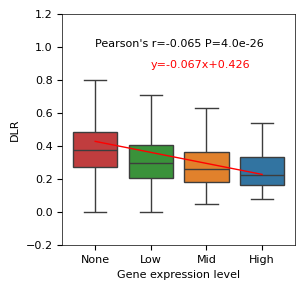

In [19]:
corr, p = pearsonr( Corr_df["Level"].values, Corr_df["values"].values ) 
print(corr, p)
plt.figure(figsize=(3,3))
palette = sns.color_palette(sns.color_palette(), 4)[::-1]
sns.boxplot(x="Level", y="values", data=Corr_df, showfliers=False, palette=palette, hue='Level')
plt.xticks([0,1,2,3], ["None", "Low", "Mid", "High"], fontsize=8)
meanval = [np.mean(Corr_df.loc[Corr_df["Level"]==n, "values"].values) for n in [0,1,2,3] ]
slope, intercept, r,p , std_err = linregress(  Corr_df["Level"].values, Corr_df["values"].values )
plt.plot(  np.array([0,1,2,3]), intercept + slope*np.array([0,1,2,3]), color="r" , zorder=10)
plt.text(x=1, y=0.8, s = f"y={slope:.3f}x+{intercept:.3f}\n",color="r", fontsize=8)
plt.text(x=0, y=1, s=f"Pearson's r={corr:.3f} P={p:.1e}", color="k")
plt.ylim([-0.2, 1.2])
# Add title and axes labels
plt.ylabel('DLR')
plt.xlabel('Gene expression level')
plt.legend().set_visible(False)
# plt.legend("")
plt.savefig(f"/data2/Hap3D_Figures/0721/HiC_DLR_gene_expression.pdf")
plt.show()